# Introduction à l'apprentissage statistique

## DM n°2

#### Jules Saget

Import des bibliothèques importantes et des données, et reprise du code de la descente de gradient

In [1]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.colors as col
import matplotlib.pyplot as plt
import os
from PIL import Image

In [2]:
def add_img(pic_path,lst):
    pic = Image.open(pic_path)
    pix = np.array(pic.getdata())
    lst.append(pix)

train_A = []
train_B = []
train_C = []
test_A  = []
test_B  = []
test_C  = []

for img_name in os.listdir('data/train/A'):
    add_img('data/train/A/'+img_name, train_A)

for img_name in os.listdir('data/train/B'):
    add_img('data/train/B/'+img_name, train_B)

for img_name in os.listdir('data/train/C'):
    add_img('data/train/C/'+img_name, train_C)

for img_name in os.listdir('data/test/A'):
    add_img('data/test/A/'+img_name, test_A)

for img_name in os.listdir('data/test/B'):
    add_img('data/test/B/'+img_name, test_B)

for img_name in os.listdir('data/test/C'):
    add_img('data/test/C/'+img_name, test_C)

x_train = np.array(train_A + train_B + train_C)
y_train = np.array([1 if k < len(train_A) else -1 for k in range(len(x_train))])
n_train = np.shape(x_train)[0]
print("Taille de l'ensemble d'entraînement :", n_train)
    
x_test = np.array(test_A + test_B + test_C)
y_test = np.array([1 if k < len(test_A) else -1 for k in range(len(x_test))])
n_test = np.shape(x_test)[0]
print("Taille de l'ensemble de test :", n_test)

Taille de l'ensemble d'entraînement : 900
Taille de l'ensemble de test : 750


In [3]:
def zero_one_loss(fx, y):
    if fx == y:
        return 0
    else:
        return 1

def zero_one_risk(X, Y, n, beta):
    bet = lambda i: 1 if beta @ X[i] > 0 else -1
    return sum([zero_one_loss(bet(i), Y[i]) / n for i in range(n)])

# Ceci est la descente de gradient stochastique
# Elle n'est pas préfixée par 'sto_' car je n'utiliserai
# pas de descente de gradient non stochastique

def grad_desc(grad, lambda_, gamma, xtrain=x_train, ytrain=y_train, ntrain=n_train, xtest=x_test, ytest=y_test, ntest=n_test, emp_risk=zero_one_risk, steps=10000, test_step=None):
    if test_step == None:
        test_step = [steps-1]
    beta = np.zeros(xtrain.shape[1])
    risks_train = []
    risks_test  = []
    betas = [beta.copy()]
    for step in range(steps):
        if step in test_step:
            risks_train.append(emp_risk(xtrain, ytrain, ntrain, beta))
            risks_test.append( emp_risk(xtest,  ytest,  ntest,  beta))
            betas.append(beta.copy())
        i = np.random.randint(ntrain)
        beta -= gamma * grad(xtrain[i], ytrain[i], beta, lambda_)
    return betas, risks_train, risks_test

### Question 1.
#### Question 1.b.

In [4]:
# On définit le gradient (stochastique) associé au problème de minimisation

def grad_log_reg(x, y, beta, lambda_):
    t = math.exp(-y * beta @ x)
    return (-t)/(1+t) * y * x + lambda_ * np.sign(beta)

In [5]:
gamma = 1e-6

risks_train = []
risks_test  = []

LAM = np.arange(0, 1001, 10)

for lam in LAM:
    _, rtr, rte = grad_desc(grad_log_reg, lam, gamma)
    risks_train.append(rtr[-1])
    risks_test.append(rte[-1])

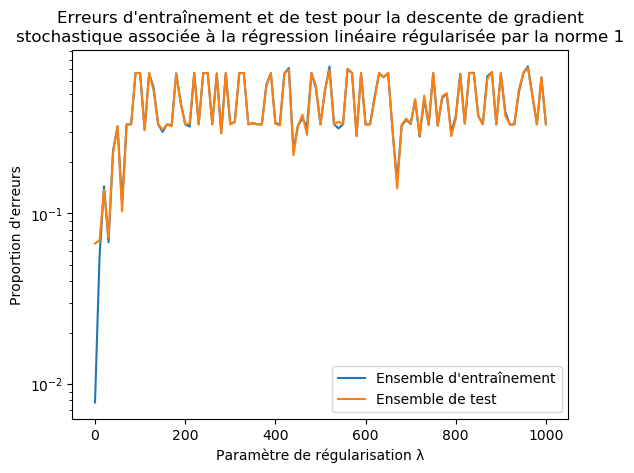

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(LAM, risks_train, label="Ensemble d'entraînement")
ax.plot(LAM, risks_test,  label="Ensemble de test")
ax.set_xlabel("Paramètre de régularisation λ")
ax.set_ylabel("Proportion d'erreurs")
plt.legend()
#plt.ylim(1e-2, 1)
plt.title("Erreurs d'entraînement et de test pour la descente de gradient\nstochastique associée à la régression linéaire régularisée par la norme 1")
ax.set_yscale('log')
plt.show()

#### Question 1.c

In [7]:
# Callibration de lambda par validation croisée
K = 5

assert n_train % K == 0, "Question 1.c, K ne divise pas n_train"
# On pourrait se passer de cette condition, mais elle
# est vérifiée en pratique et simplifie le code

size = n_train // K

permut = list(np.random.permutation(n_train))

sets = [permut[i * size : (i+1) * size] for i in range(K)]

errors = np.zeros((len(LAM), K))

In [8]:
ntr = n_train * (K-1) // K
nte = n_train // K

for i in range(K):
    cur_test = sets[i]
    cur_train = []
    for j in range(K):
        if i != j:
            cur_train.extend(sets[j])
    xtr = x_train[cur_train]
    ytr = y_train[cur_train]
    xte = x_train[cur_test]
    yte = y_train[cur_test]
    for lami in range(len(LAM)):
        lam = LAM[lami]
        _, _, rte = grad_desc(grad_log_reg, lam, gamma, xtrain=xtr, ytrain=ytr, ntrain=ntr, xtest=xte, ytest=yte, ntest=nte)
        error = rte[-1]
        errors[lami, i] = error

In [9]:
quad_errors = np.zeros(len(LAM))

for lami in range(len(LAM)):
    for err in errors[lami]:
        quad_errors[lami] += (err)**2
    quad_errors[lami] = math.sqrt(quad_errors[lami])/(K)

best_lami, = np.where(quad_errors == min(quad_errors))
best_lami = best_lami[0]

LAM_sorted = LAM[np.argsort(quad_errors)]

best_lambda = LAM_sorted[0]

print(best_lambda)

0


#### Question 1.d

In [10]:
N_samples = 4 # nombre d'échantillons souhaités

betas = []

LAMS = [LAM_sorted[k * len(LAM) // (N_samples-1)] for k in range(N_samples-1)] + [LAM_sorted[-1]]

for lam in LAMS:
    beta, _, _ = grad_desc(grad_log_reg, lam, gamma)
    betas.append(beta[-1])

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


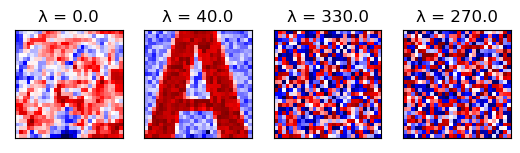

In [11]:
#norm = col.Normalize(vmin=np.min(betas), vmax=np.max(betas))

fig, axes = plt.subplots(ncols=N_samples)

for ax, k in zip(axes, range(N_samples)):
    beta = betas[k]
    beta_sq = np.array([[beta[i*28+j] for j in range(28)] for i in range(28)])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    im = ax.imshow(beta_sq, cmap='seismic', interpolation='none')
    ax.set_title("λ = "+str(int(100*LAMS[k])/100))
fig.show()


#### Question 1.e

In [12]:
def grad_log_reg2(x, y, beta, lambda_):
    t = math.exp(-y * beta @ x)
    return (-t)/(1+t) * y * x + lambda_ * 2 * beta

In [13]:
gamma = 1e-6

risks_train = []
risks_test  = []

LAM = np.arange(0, 2001, 10)

for lam in LAM:
    _, rtr, rte = grad_desc(grad_log_reg2, lam, gamma)
    risks_train.append(rtr[-1])
    risks_test.append(rte[-1])

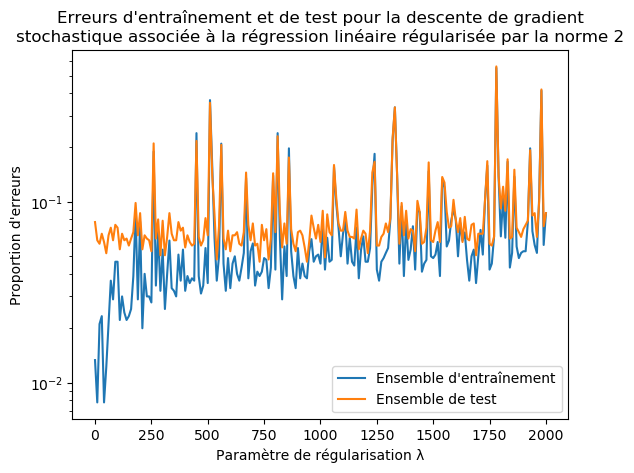

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(LAM, risks_train, label="Ensemble d'entraînement")
ax.plot(LAM, risks_test,  label="Ensemble de test")
plt.legend()
ax.set_xlabel("Paramètre de régularisation λ")
ax.set_ylabel("Proportion d'erreurs")
plt.title("Erreurs d'entraînement et de test pour la descente de gradient\nstochastique associée à la régression linéaire régularisée par la norme 2")
ax.set_yscale('log')
plt.show()

In [15]:
# Callibration de lambda par validation croisée
K = 5

assert n_train % K == 0, "Question 1.c, K ne divise pas n_train"
# On pourrait se passer de cette condition, mais elle
# est vérifiée en pratique et simplifie le code

size = n_train // K

permut = list(np.random.permutation(n_train))

sets = [permut[i * size : (i+1) * size] for i in range(K)]

errors = np.zeros((len(LAM), K))

In [16]:
ntr = n_train * (K-1) // K
nte = n_train // K

for i in range(K):
    cur_test = sets[i]
    cur_train = []
    for j in range(K):
        if i != j:
            cur_train.extend(sets[j])
    xtr = x_train[cur_train]
    ytr = y_train[cur_train]
    xte = x_train[cur_test]
    yte = y_train[cur_test]
    for lami in range(len(LAM)):
        lam = LAM[lami]
        _, _, rte = grad_desc(grad_log_reg2, lam, gamma, xtrain=xtr, ytrain=ytr, ntrain=ntr, xtest=xte, ytest=yte, ntest=nte)
        error = rte[-1]
        errors[lami, i] = error

In [17]:
quad_errors = np.zeros(len(LAM))

for lami in range(len(LAM)):
    for err in errors[lami]:
        quad_errors[lami] += (err)**2
    quad_errors[lami] = math.sqrt(quad_errors[lami])/(K)

best_lami, = np.where(quad_errors == min(quad_errors))
best_lami = best_lami[0]

LAM_sorted = LAM[np.argsort(quad_errors)]

best_lambda = LAM_sorted[0]

print(best_lambda)

240


### Question 2

#### Question 2.c

In [18]:
pi = 1/3

treshold = int(pi*n_train)
As = np.array(train_A)
BCs = np.array(train_B + train_C)

mu_A = sum(As) / treshold

mu_BC = sum(BCs) / (n_train-treshold)

As_mat = [np.matrix(A - mu_A) for A in As]
BCs_mat = [np.matrix(BC - mu_BC) for BC in BCs]
sigma = 1/n_train * (sum([A.T @ A for A in As_mat]) + sum([BC.T @ BC for BC in BCs_mat]))
sigma_inv = np.linalg.inv(sigma)

In [19]:
def lda_is_A(x):
    in_e_1 = - x.T @ sigma_inv @ (mu_A - mu_BC)
    in_e_2 = - 1/2 * mu_BC.T @ sigma_inv @ mu_BC
    in_e_3 =   1/2 * mu_A.T  @ sigma_inv @ mu_A
    in_e_4 = - math.log(pi/(1-pi))
    in_e = in_e_1 + in_e_2 + in_e_3 + in_e_4
    return in_e < 0

In [20]:
confusion_test = np.zeros((2,2), dtype = int)

for i in range(n_test):
    if y_test[i] == 1:
        x=0
    else:
        x=1
    if lda_is_A(x_test[i]):
        y=0
    else:
        y=1
    confusion_test[x,y] += 1

print(confusion_test)

[[206  44]
 [105 395]]


In [21]:
confusion_train = np.zeros((2,2), dtype=int)

for i in range(n_train):
    if y_train[i] == 1:
        y=0
    else:
        y=1
    if lda_is_A(x_train[i]):
        x=0
    else:
        x=1
    confusion_train[x,y] += 1

confusion_train[:,0] = confusion_train[:,0]/(n_train/3)
confusion_train[:,1] = confusion_train[:,1]/(n_train/3*2)
    
print(confusion_train)

[[1 0]
 [0 1]]


### Question 3
#### Question 3.a

In [59]:
# K-moyennes

def get_class(x, centers):
    dist_tbl = [np.linalg.norm(center - x) for center in centers]
    return np.argmin(dist_tbl)

def vect_average(cluster):
    return sum(cluster)/len(cluster)

def get_clusters(data, centers, n = None):
    if n == None:
        n = len(centers)
    assert n == len(centers), "n doit valoir la taille de centers"
    clusters = [[] for k in range(n)]
    for point in data:
        cluster_i = get_class(point, centers)
        clusters[cluster_i].append(point)
    return clusters

def k_means_one_iter(data, n):
    # On gérère les centres aléatoirement
    centers = np.array(data[np.random.permutation(len(data))[:n]])
    last_centers = centers * 0
    while (centers != last_centers).any():
        last_centers = centers.copy()
        # On inititalise les clusters à []
        # Pas possible de faire plus simple si on veut un array
        clusters = get_clusters(data, centers, n)
        for i in range(n):
            centers[i] = vect_average(clusters[i])
        centers = np.array(centers)
    return centers

def k_means(data, n, iters=1):
    centers = data[:n] * 0.
    for i in range(iters):
        centers += k_means_one_iter(data, n)
    centers /= iters
    return(centers)

centers = k_means(x_train, 3, iters=10)
clusters = get_clusters(x_train, centers)

In [60]:
x_train_centered = x_train - vect_average(x_train)
xtc = x_train_centered

def pca(xtc, dim):
    e_val, e_vec = np.linalg.eig(xtc.T @ xtc)
    return e_vec[np.argsort(e_val)[:dim]]

pca_x = pca(xtc, 2)

In [61]:
def project_cluster(cluster, pca):
    n = len(pca)
    return [np.array([pca[k] @ point for k in range(n)]) for point in cluster]

def project_clusters(clusters, pca):
    n = len(pca)
    p_clusters = [project_cluster(cluster, pca) for cluster in clusters]
    return p_clusters

clusters_2d = project_clusters(clusters, pca_x)
centers_2d = project_cluster(centers, pca_x)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


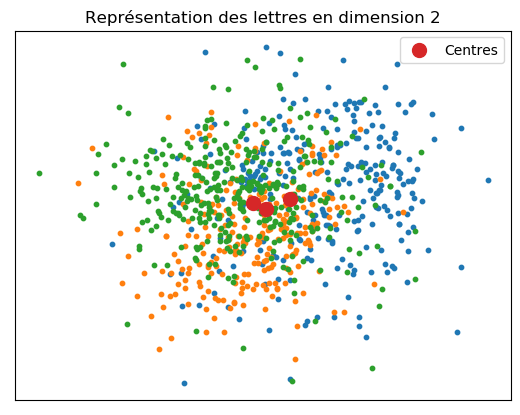

In [62]:
def get_scatter(S, size=10):
    # Pour avoir les données au bon format
    # pour ax.scatter
    x = []
    y = []
    sizes = []
    for elt in S:
        x.append(elt[0])
        y.append(elt[1])
        sizes.append(size)
    return x, y, size

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for cluster in clusters_2d:
    x, y, size = get_scatter(cluster)
    ax.scatter(x, y, size)
x, y, size = get_scatter(centers_2d, 100)
ax.scatter(x, y, size, label = "Centres", cmap=[100,100,100])
ax.legend()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Représentation des lettres en dimension 2")
fig.show()

In [63]:
def is_in_array(x, S):
    for elt in S:
        if (x==elt).all():
            return True
    return False

def get_clust_id(point, clusters):
    for cluster_id in range(len(clusters)):
        if is_in_array(point, clusters[cluster_id]):
            return cluster_id
    return -1

def get_clust_ids(data, clusters):
    clust_ids = np.zeros(len(data), dtype=int)
    for point_id in range(len(data)):
        clust_ids[point_id] = get_clust_id(data[point_id], clusters)
    return clust_ids

cis = get_clust_ids(x_train, clusters)

In [64]:
confusion = np.zeros((3,3), dtype = int)

for i in range(n_train//3):
    confusion[0,cis[i]] +=1

for i in range(n_train//3, 2*n_train//3):
    confusion[1,cis[i]] +=1

for i in range(2*n_train//3, n_train):
    confusion[2,cis[i]] +=1
    
print(confusion)

[[ 45   6 249]
 [204  42  54]
 [ 40 215  45]]


In [66]:
def get_letter(letter_id):
    return chr(ord('A') + letter_id)

def reorder(conf, clusters, centers):
    maxs = [np.argmax(letter) for letter in conf]
    c = conf.T
    return(c[maxs].T, [clusters[i] for i in maxs], centers[maxs])

nconfusion, nclusters, ncenters = reorder(confusion, clusters, centers)
print(nconfusion)

[[249  45   6]
 [ 54 204  42]
 [ 45  40 215]]


[118.50405689773362, 164.89233954773266, 134.83425791033574] [-54.430511100903004, -48.14984146959602, -62.154368506153666]


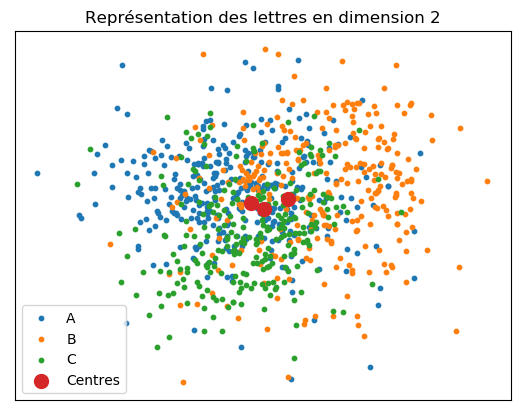

In [70]:
nclusters_2d = project_clusters(nclusters, pca_x)
ncenters_2d = project_cluster(ncenters, pca_x)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for cluster_i in range(len(nclusters_2d)):
    x, y, size = get_scatter(nclusters_2d[cluster_i])
    ax.scatter(x, y, size, label=get_letter(cluster_i))
    ax.legend()
x, y, size = get_scatter(ncenters_2d, 100)
print(x,y)
ax.scatter(x, y, size, label = "Centres", cmap=[100,100,100])
ax.legend()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Représentation des lettres en dimension 2")
plt.show()